In [1]:
import numpy as np
import scipy
import sklearn.datasets

dataset = sklearn.datasets.fetch_covtype(shuffle=True, random_state=42)
len(dataset.data)

581012

Name | Data Type | Measurement | Description
-----|-----------|-------------|------------
Elevation | quantitative |meters | Elevation in meters
Aspect | quantitative | azimuth | Aspect in degrees azimuth
Slope | quantitative | degrees | Slope in degrees
Horizontal_Distance_To_Hydrology | quantitative | meters | Horz Dist to nearest surface water features
Vertical_Distance_To_Hydrology | quantitative | meters | Vert Dist to nearest surface water features
Horizontal_Distance_To_Roadways | quantitative | meters | Horz Dist to nearest roadway
Hillshade_9am | quantitative | 0 to 255 index | Hillshade index at 9am, summer solstice
Hillshade_Noon | quantitative | 0 to 255 index | Hillshade index at noon, summer soltice
Hillshade_3pm | quantitative | 0 to 255 index | Hillshade index at 3pm, summer solstice
Horizontal_Distance_To_Fire_Points | quantitative | meters | Horz Dist to nearest wildfire ignition points
Wilderness_Area (4 binary columns) | qualitative | 0 (absence) or 1 (presence) | Wilderness area designation
Soil_Type (40 binary columns) | qualitative | 0 (absence) or 1 (presence) | Soil Type designation
Cover_Type (7 types) | integer | 1 to 7 | Forest Cover Type designation

In [2]:
dataset.data[0]

array([  3.35100000e+03,   2.06000000e+02,   2.70000000e+01,
         7.26000000e+02,   1.24000000e+02,   3.81300000e+03,
         1.92000000e+02,   2.52000000e+02,   1.80000000e+02,
         2.27100000e+03,   1.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [3]:
dataset.target[0]

1

In [4]:
num_input_features = dataset.data.shape[1]
num_input_features

54

In [5]:
num_classes = dataset.target.max()
num_classes

7

In [6]:
num_dev_samples = num_test_samples = len(dataset.data) // 10
num_train_samples = len(dataset.data) - num_dev_samples - num_test_samples
training_data = {"features": dataset.data[:num_train_samples], "labels": dataset.target[:num_train_samples]}
dev_data = {"features": dataset.data[num_train_samples:num_train_samples+num_dev_samples],
       "labels": dataset.target[num_train_samples:num_train_samples+num_dev_samples]}
test_data = {"features": dataset.data[-num_test_samples:],
       "labels": dataset.target[-num_test_samples:]}

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    expx = np.exp(x)
    return expx / np.sum(expx)

class Model:
    def __init__(self, num_input_features, num_hidden_features, num_output_features):
        self.weights1 = np.random.normal(0, 0.25, (num_input_features, num_hidden_features))
        self.biases1 = np.zeros((num_hidden_features,))
        self.weights2 = np.random.normal(0, 0.25, (num_hidden_features, num_output_features))
        self.biases2 = np.zeros((num_output_features,))
    
    def predict(self, features, label=None):
        hidden_features = sigmoid(np.matmul(features, self.weights1) + self.biases1)
        output_features = softmax(np.matmul(hidden_features, self.weights2) + self.biases2)
        if label is not None:
            loss = -np.log(output_features[label])
            return output_features, loss
        return output_features
    
    def compute_loss_and_gradients(self, features, label):
        hidden_preactivations = np.matmul(features, self.weights1) + self.biases1
        hidden_features = sigmoid(hidden_preactivations)
        output_preactivations = np.matmul(hidden_features, self.weights2) + self.biases2
        output_features = softmax(output_preactivations)
        loss = -np.log(output_features[label])
        
        output_preactivations_gradients = output_features
        output_preactivations_gradients[label] -= 1
        
        biases2_gradients = output_preactivations_gradients
        weights2_gradients = np.outer(hidden_features, output_preactivations_gradients)
        hidden_features_gradients = np.matmul(output_preactivations_gradients, self.weights2.T)
        
        hidden_preactivations_gradients = hidden_features_gradients * (hidden_features * (1 - hidden_features))
        biases1_gradients = hidden_preactivations_gradients
        weights1_gradients = np.outer(features, hidden_preactivations_gradients)
        return loss, (weights1_gradients, biases1_gradients, weights2_gradients, biases2_gradients)
    
    def update_parameters(self, gradients, learning_rate):
        parameters = (self.weights1, self.biases1, self.weights2, self.biases2)
        for param, grad in zip(parameters, gradients):
            param -= grad * learning_rate

In [8]:
means = np.mean(training_data["features"], axis=0)
stds = np.std(training_data["features"], axis=0)

In [9]:
from tqdm.notebook import tqdm
model = Model(num_input_features, 4, num_classes)
pbar = tqdm(total=num_train_samples, ncols="100%")
learning_rate = 0.005
evaluate_every = 20000
train_log = []
dev_log = []
train_losses = []

for step in range(num_train_samples):
    features = training_data["features"][step]
    features = (features - means) / stds
    label = training_data["labels"][step] - 1
    
    loss, gradients = model.compute_loss_and_gradients(features, label)
    train_losses.append(loss)
    
    if step % evaluate_every == 0:
        dev_losses = []
        for j in range(num_dev_samples):
            dev_features = dev_data["features"][j]
            dev_features = (dev_features - means) / stds
            dev_label = dev_data["labels"][j] - 1
            dev_output, dev_loss = model.predict(dev_features, dev_label)
            dev_losses.append(dev_loss)
        
        dev_mean_loss = np.mean(dev_losses)
        dev_log.append(dev_mean_loss)
        train_mean_loss = np.mean(train_losses)
        train_log.append(train_mean_loss)
        pbar.set_description(f"train: {train_mean_loss:.2f}, dev: {dev_mean_loss:.2f}")
    
    model.update_parameters(gradients, learning_rate)
    pbar.update()
pbar.close()

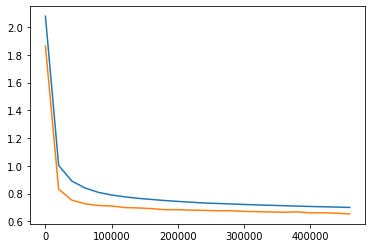

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_log)) * evaluate_every, train_log)
plt.plot(np.arange(len(dev_log)) * evaluate_every, dev_log)

In [13]:
correct = 0
for i in range(num_test_samples):
    features = test_data["features"][i]
    features = (features - means) / stds
    label = test_data["labels"][i] - 1
    prediction = model.predict(features).argmax()
    if prediction == label:
        correct += 1
accuracy = correct / num_test_samples
print(f"Test Accuracy: {accuracy:.1%}")

Test Accuracy: 72.8%
